In [ ]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=2

In [2]:
# some imports
import sys
import warnings
warnings.filterwarnings("ignore")

from copy import copy

import numpy as np
from scipy.special import binom
from scipy.ndimage.morphology import binary_fill_holes
import torch.nn as nn
from tqdm.notebook import tqdm_notebook

sys.path.append('../../..')

from seismiqb import *
from seismiqb.src.controllers.torch_models import ExtensionModel

from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow import D, B, V, P, R, L

In [3]:
def bezier_figure(key_points_amount=7, radius=0.2, sharpness=0.05, scale=1.0, plot_size=(1, 1), 
                  resolution=None, unscaled_points_distance=.5, points_search_stop_iter=100):
    """ Bezier closed curve coordinates.        
    Creates Bezier closed curve which passes through random points.
    Code based on:  https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib    

    Parameters
    ----------
    key_points_amount : int
        Amount of angles (key points) in the random figure. Must be more than 1.
    radius : float
        Distance to control middle points in Bezier algorithm. 
        Is a number between 0 and 1.
    sharpness : float
        Degree of sharpness/edgy. If edgy=0 then curve is the smoothest.
    scale : float
        Figure scale. Is a number between 0 and 1. Fits to the plot_size.
    plot_size : iterable sequence of two int numbers
        Size of plotting area.
    resolution : int
        Amount of points in one curve between two key points.
    unscaled_points_distance : float
        Distance between key points in a unit square. A number between 0 and 1.
    points_search_stop_iter : int
        Stop criterion for search of key points.
    """        
    resolution = resolution or int(scale*max(plot_size)*100)
    
    # Get key points of figure as random points which are far enough each other        
    key_points = np.random.rand(key_points_amount, 2)
    unscaled_points_distance = unscaled_points_distance**2
    
    for i in range(points_search_stop_iter):
        # Found distances between points and sort key_points by angles         
        shifted_points = key_points - np.mean(key_points, axis=0)
        angles = np.arctan2(shifted_points[:, 0], shifted_points[:, 1])
        key_points = key_points[np.argsort(angles)]

        squared_distances = np.sum(np.diff(key_points, axis=0)**2, axis=1)
        if np.all(squared_distances >= unscaled_points_distance):
            break
        key_points = np.random.rand(key_points_amount, 2)

    key_points *= scale*np.array(plot_size, float)
    key_points = np.vstack([key_points, key_points[0]]) 

    # Calculate figure angles in key points
    p = np.arctan(sharpness) / np.pi + .5
    diff_between_points = np.diff(key_points, axis=0)
    angles = np.arctan2(diff_between_points[:, 1], diff_between_points[:, 0])    
    angles = angles + 2*np.pi*(angles < 0)
    rolled_angles = np.roll(angles, 1)
    angles = p*angles + (1 - p)*rolled_angles + np.pi*(np.abs(rolled_angles - angles) > np.pi)
    angles = np.append(angles, angles[0])        

    # Create figure part by part: make curves between each pair of points
    curve_segments = []
    # Calculate control points for Bezier curve
    points_distances = np.sqrt(np.sum(diff_between_points**2, axis=1))
    radii = radius*points_distances
    middle_control_points_1 = np.transpose(radii*[np.cos(angles[:-1]), 
                                                  np.sin(angles[:-1])]) + key_points[:-1]
    middle_control_points_2 = np.transpose(radii*[np.cos(angles[1:] + np.pi), 
                                                  np.sin(angles[1:] + np.pi)]) + key_points[1:]
    curve_main_points_arr = np.hstack([key_points[:-1], middle_control_points_1,
                                       middle_control_points_2, key_points[1:]]).reshape(key_points_amount, 4, -1)
    
    # Get Bernstein polynomial approximation of each curve
    for i in range(key_points_amount):
        bezier_param_t = np.linspace(0, 1, num=resolution)            
        current_segment = np.zeros((resolution, 2))
        for point_num, point in enumerate(curve_main_points_arr[i]):
            polynomial_degree = np.power(bezier_param_t, point_num)
            polynomial_degree *= np.power(1 - bezier_param_t, 3 - point_num)
            bernstein_polynomial = binom(3, point_num)*polynomial_degree
            current_segment += np.outer(bernstein_polynomial, point)
        curve_segments.extend(current_segment)
        
    curve_segments = np.array(curve_segments)
    xy = np.unique(np.ceil(curve_segments).astype(int), axis=0)
    return xy 

In [4]:
def random_figures(horizon, geometry, figures_amount=10, noisy=False, scale=1.0, positions=None):
    """ Create matrix of random holes for horizon.        
   
    Parameters
    ----------
    horizon : Horizon
        Instance of Horizon class. It is necessary for figures scale and positions.
    geometry
        Geometry of horizon.
    figures_amount : int
        Amount of holes on horizon.
    noisy : bool
        Whether to make figures with noisy borders.
    scale : float or iterable float sequence of length equals to figures_amount. 
        A numbers between 0 and 1.
        if float, each figure will have a random scale from exponential distribution.
        if sequence, each figure will have an individual fixed scale.
    positions : iterable int sequence of size equals to figures_amount*2
        Figures positions on horizon.
        if None, positions will be random.
        if sequence, positions will be fixed for each figure.
    """  
    geometry_shape = geometry.zero_traces.shape
    filtering_matrix = np.zeros_like(geometry.zero_traces)
    
    key_points_amount_arr = np.random.random_integers(2, 5, figures_amount)
    radius_arr = np.random.random(figures_amount)
    sharpness_arr = np.random.random(figures_amount)*np.random.random_integers(1, 5, figures_amount)
    
    if isinstance(scale, float):
        add_scale = []
        while len(add_scale) < figures_amount:
            new_scale = np.random.exponential(scale, size=(figures_amount-len(add_scale))*10)
            new_scale = new_scale[new_scale < .25]
            add_scale.extend(new_scale)
        scale = add_scale[:figures_amount]
        
    if positions is None:
        # Choose random non-bad traces
        traces_idxs = np.where(geometry.zero_traces == 0)
        positions_idxs = np.random.randint(0, len(traces_idxs[0]), figures_amount)
        positions = np.transpose(np.vstack([traces_idxs[0][positions_idxs],
                                            traces_idxs[1][positions_idxs]]))
        
    for i in range(figures_amount):
        xy = bezier_figure(key_points_amount_arr[i], 
                             radius_arr[i], sharpness_arr[i], 
                             scale[i], geometry_shape)
        xy += positions[i, :]
               
        if noisy:
            noise = np.random.randint(-10, 10, xy.shape) + xy
            xy = np.unique(np.vstack([xy, noise]), axis=0)
        
        #Shift figure in plotting area
        nonzero_borders = np.min(xy, axis=0)
        nonbig_borders = np.max(xy, axis=0)   
        for j in range(2):
            nonzero_border = min(0, nonzero_borders[j])
            nonbig_border = max(nonbig_borders[j], geometry_shape[j]) - geometry_shape[j]
            xy[:, j] -= (nonbig_border + nonzero_border + 1)

        # Cut figure if it is too big
        suited_x = (xy[:, 0] < geometry_shape[0]) & (xy[:, 0] >= 0)
        suited_y = (xy[:, 1] < geometry_shape[1]) & (xy[:, 1] >= 0)
        xy = xy[suited_x & suited_y]
        filtering_matrix[xy[:, 0], xy[:, 1]] = 1
    filtering_matrix = binary_fill_holes(filtering_matrix)
    return filtering_matrix

In [5]:
def add_noise(horizon, geometry, points_amount=None):
    """ Create matrix of random point holes for horizon.        
   
    Parameters
    ----------
    horizon : Horizon
        Instance of Horizon class. It is necessary for figures scale and positions.
    geometry
        Geometry of horizon.
    points_amount : int
        Amount of point holes on horizon. If None amount will be a random number.
    """
    filtering_matrix = np.zeros_like(geometry.zero_traces)
    geometry_shape = geometry.zero_traces.shape
    if points_amount is None:
        points_amount = np.random.randint(geometry.zero_traces.size//1e5, geometry.zero_traces.size//1e4)
    x = np.random.randint(0, geometry_shape[0], points_amount)
    y = np.random.randint(0, geometry_shape[1], points_amount)
    filtering_matrix[x, y] = 1
    return filtering_matrix

# Load horizon

In [6]:
cube_path = "/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5"
horizon_dir = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_B_anon'

In [7]:
dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load(horizon_dir)
dataset.create_labels({dataset.indices[0]: [horizon_dir]})
dataset.modify_sampler(dst='train_sampler', finish=True)

geometry = dataset.geometries[0]
horizon = dataset.labels[0][0]

In [8]:
init_horizon_copy = horizon.__copy__()

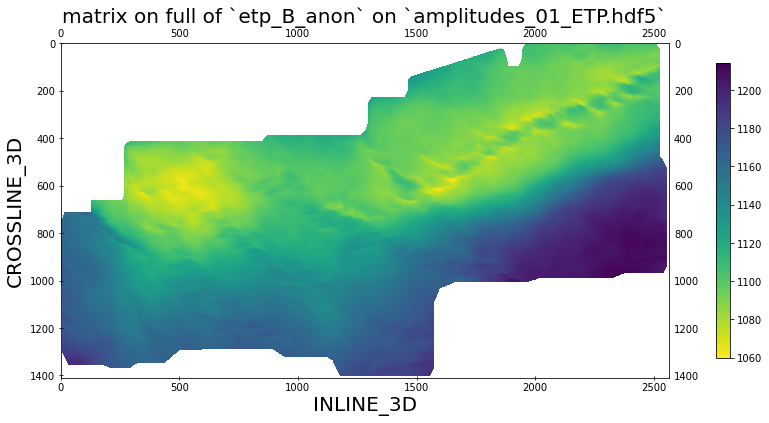

In [9]:
horizon.show()

# Simple random figures

In [10]:
np.random.seed(0)

In [11]:
%%time
filtering_matrix = random_figures(horizon, geometry, figures_amount=20, noisy=False, scale=1.0, positions=None)

CPU times: user 1.92 s, sys: 29.2 ms, total: 1.95 s
Wall time: 1.95 s


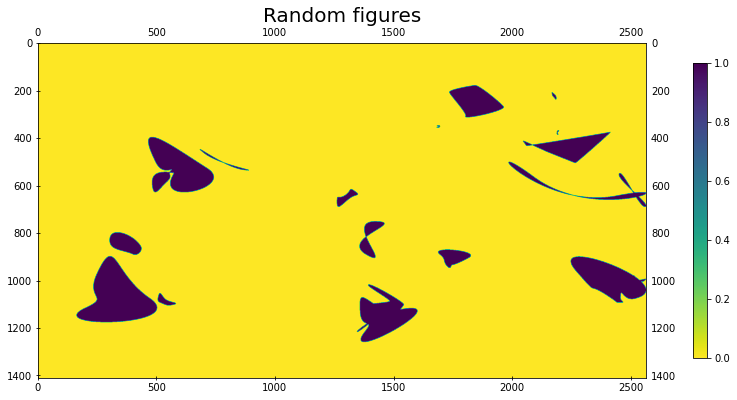

In [12]:
plot_image(filtering_matrix, title="Random figures")

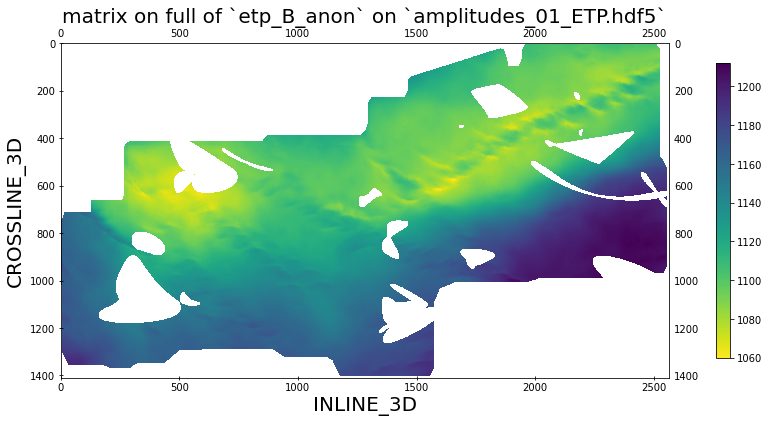

In [13]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()

# Noisy random figures

In [14]:
horizon = init_horizon_copy.__copy__()
# np.random.seed(0)

In [15]:
%%time
filtering_matrix = random_figures(horizon, geometry, figures_amount=20, noisy=True, scale=1.0, positions=None)

CPU times: user 2.67 s, sys: 56.2 ms, total: 2.73 s
Wall time: 2.73 s


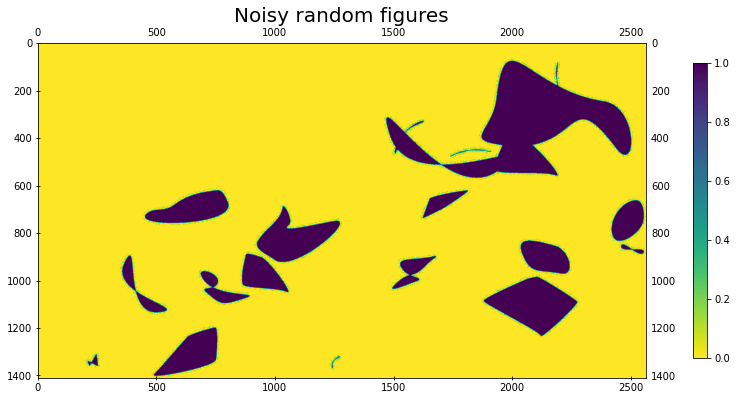

In [16]:
plot_image(filtering_matrix, title="Noisy random figures")

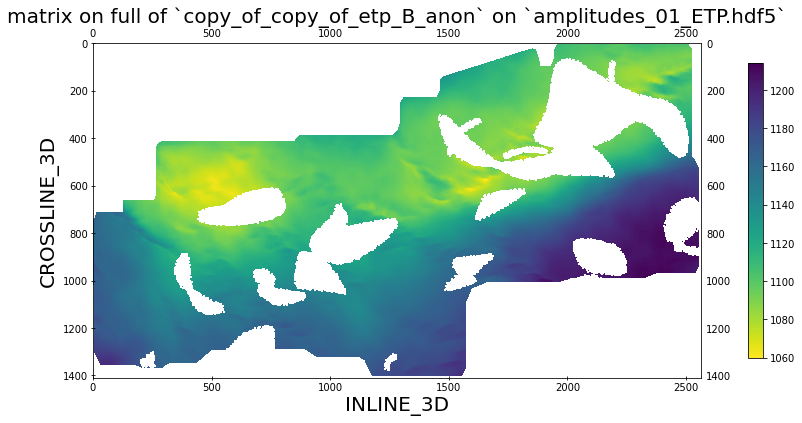

In [17]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()

# Noisy random figures and point holes

In [18]:
horizon = init_horizon_copy.__copy__()
# np.random.seed(0)

In [19]:
%%time
filtering_matrix1 = random_figures(horizon, geometry, figures_amount=20, noisy=True, scale=1.0, positions=None)
filtering_matrix2 = add_noise(horizon, geometry)
filtering_matrix = filtering_matrix1 | filtering_matrix2

CPU times: user 2.3 s, sys: 29.6 ms, total: 2.33 s
Wall time: 2.33 s


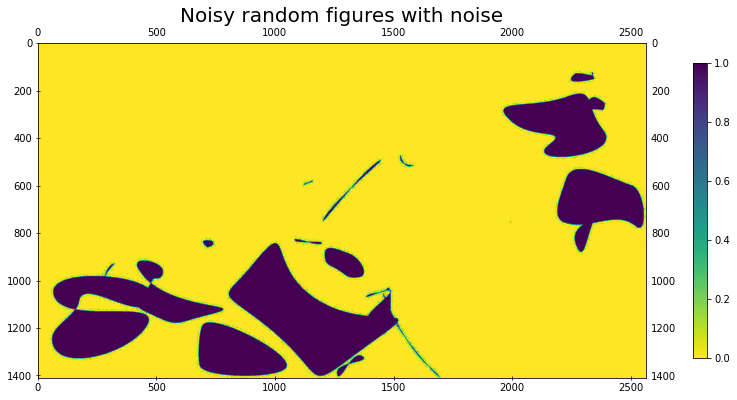

In [20]:
plot_image(filtering_matrix, title="Noisy random figures with noise")

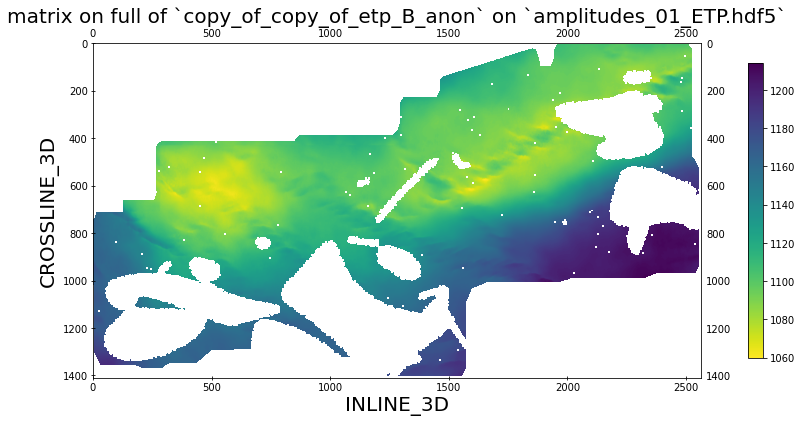

In [21]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()